In [11]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib as mpl
from datetime import datetime, date, time, timedelta

In [26]:
# import data
#
#
#
#
#
#

raw_df = pd.read_csv('cleaned_urx_data.csv')
raw_df.columns

Index([u'Unnamed: 0', u'_unit_id', u'_created_at', u'_golden', u'_id',
       u'_missed', u'_started_at', u'_tainted', u'_channel', u'_trust',
       u'_worker_id', u'_country', u'_region', u'_city', u'_ip',
       u'please_make_your_relevancy_judgment', u'orig__created_at',
       u'orig__golden', u'orig__unit_id', u'_updated_at', u'endurl', u'nil',
       u'please_make_your_relevancy_judgment_gold',
       u'please_make_your_relevancy_judgment_gold_reason', u'query',
       u'starturl', u'type'],
      dtype='object')

In [ ]:
### manipulation of data

# dict of created times and ids
created_at_dict = dict()
for line in raw_df.groupby('_worker_id')['_created_at']:
    created_at_dict[line[0]] = line[1]
    
# dict of started times and ids    
started_at_dict = dict()
for line in raw_df.groupby('_worker_id')['_started_at']:
    started_at_dict[line[0]] = line[1]
    
# dict of scores and ids
scores_dict = dict()
for line in raw_df.groupby('_worker_id')['please_make_your_relevancy_judgment']:
    scores_dict[line[0]] = list(line[1]) #coerce to list bc i hate indexing on the series
    
# dict of trust and ids
trust_dict = dict()
for line in raw_df.groupby('_worker_id'):
    trust_dict[line[0]] = line[1]['_trust'][line[1]['_trust'].keys()[1]]
    

In [ ]:
## identify diversity in job creation, job start time differences  

# takes a list of datetime strings and returns a list of datetime objects
def make_list_datetime(list_of_time_strings):
    date_time_list = []
    for time in list_of_time_strings:
        date_time_list.append(datetime.strptime(time, "%m/%d/%Y %H:%M:%S"))
    return date_time_list


# take in lists of creation, start datetime strings, output list of differences in seconds 
def creation_start_dif(creation_list, start_list):
    # make all into datetime objects 
    creation_datetimes = make_list_datetime(creation_list)
    start_datetimes = make_list_datetime(start_list)
    
    # iterate through to calculate each difference 
    creation_start_diffs = []
    indexer = range(0,len(creation_datetimes))
    for index in indexer:
        diff = creation_datetimes[index] - start_datetimes[index]
        creation_start_diffs.append(diff.total_seconds())    
    return creation_start_diffs

def get_diversity_score(created_dict, started_dict ):

    # produce the list of differences for each worker 
    creation_time = created_dict.values()
    started_time = started_dict.values()
    
    creation_start_diff_list = []
    indexer = range(0,len(started_time))
    for index in indexer:
        diff_list = creation_start_dif(creation_time[index], started_time[index])
        creation_start_diff_list.append(diff_list)
    
    # calculate the diversity measure
    diversity_list = []
    
    for ind_list in creation_start_diff_list:
        uniques = len(set(ind_list)) + 0.0
        diversity = uniques/len(ind_list)
        diversity_list.append(diversity)
    
    return diversity_list, creation_start_diff_list

diversity_scores, diff_list = get_diversity_score(created_at_dict, started_at_dict)

too_little_diversity = []
for diversity_score in diversity_scores:
    too_little_diversity.append(int(diversity_score < .08))
    

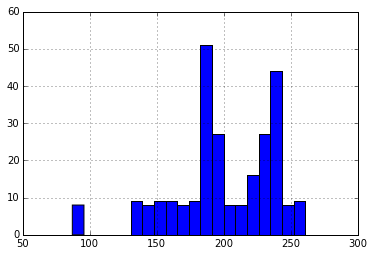

In [45]:
pd.Series(data=diff_list[1]).hist(bins = 20)

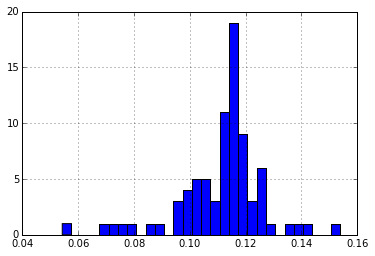

In [36]:
pd.Series(data=diversity_scores).hist(bins=30)

In [ ]:
# get job counts, variance, and mean for each worker 
worker_job_count = []
worker_variance = []
worker_mean = []
for worker in scores_dict.values():
    worker_job_count.append(len(worker))
    worker_variance.append(np.var(worker))
    worker_mean.append(np.mean(worker))

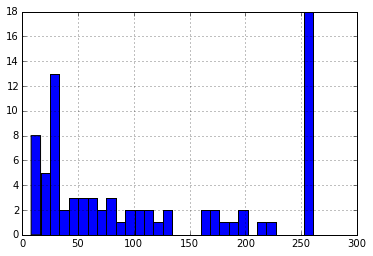

In [29]:
pd.Series(data=worker_job_count).hist(bins=30)

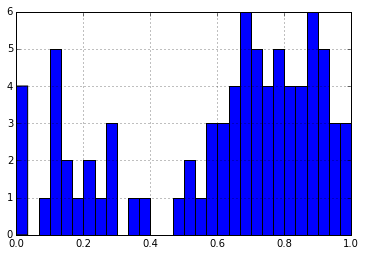

In [31]:
pd.Series(data=worker_variance).hist(bins = 30)

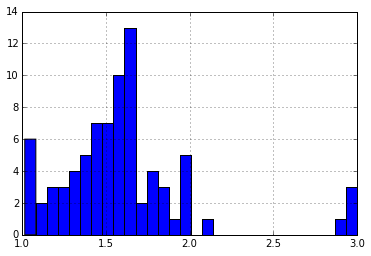

In [33]:
pd.Series(data=worker_mean).hist(bins = 30)

In [17]:
## ## judge the job counts and variance  
too_many_jobs = []
too_little_variance = []

indexer = range(0, len(worker_job_count))
for index in indexer:
    too_many_jobs.append(int(worker_job_count[index] > 150))
    too_little_variance.append(int(worker_variance[index] < .2))

In [18]:
## judge the average 
##

all_scores = raw_df['please_make_your_relevancy_judgment']

subtract = min(all_scores)
norm_scores = all_scores - min(all_scores)
divide_by = max(norm_scores)
norm_scores = all_scores / max(norm_scores)


true_mu = np.mean(norm_scores) + 0.0

low_ci = []
high_ci = []

for scores in scores_dict.values():
    # normalize 
    scores = scores - subtract
    scores = scores / divide_by
    
    mu = np.mean(scores)
    z = 1.96
    other_part = (true_mu)*(1-true_mu)/len(scores)
    other_part = other_part ** .5
    low_ci_val = mu - z*other_part
    high_ci_val = mu + z*other_part
    low_ci.append(low_ci_val)
    high_ci.append(high_ci_val)


normalized_worker_mean = []

for mean in worker_mean:
    new_mean = mean - subtract
    new_mean = new_mean / divide_by
    normalized_worker_mean.append(new_mean)
    
unreasonable_mean = []
    
# is the average unreasoanble? 
indexer = range(0, len(worker_mean))
for index in indexer:
    if normalized_worker_mean[index] > high_ci[index]:
        unreasonable_mean.append(1)
    elif normalized_worker_mean[index] < low_ci[index]:
        unreasonable_mean.append(1)
    else:
        unreasonable_mean.append(0)


In [19]:
worker_df = pd.DataFrame()
worker_df['_worker_id'] = created_at_dict.keys()
worker_df['too_many_jobs'] = too_many_jobs
worker_df['too_little_variance'] = too_little_variance
worker_df['unreasonable_mean'] = unreasonable_mean
worker_df['suspicious_timestamps'] = too_little_diversity
worker_df['_trust'] = trust_dict.values()
worker_df['agg_score'] = worker_df.ix[:, worker_df.columns != '_worker_id'].apply(sum, axis=1)

In [21]:
# although i do this later, ti's good to see these things here  

workers = worker_df
# identify humans vs. robots 
humans = workers['agg_score'].apply(lambda x: x < 2)
robots = 1-humans
human_ids = workers['_worker_id'][humans]
robot_ids = workers['_worker_id'][robots]
print "there are " + str(sum(robots)) + " out of " + str(len(robots)) + " total workers"

there are 12 out of 80 total workers


In [22]:
# remove the scores attributable to robots 
human_rows = raw_df['_worker_id'].apply(lambda x: x in set(human_ids))
humans_only = raw_df[human_rows]

print "this eliminates " + str(len(raw_df) - len(humans_only)) + " out of " + str(len(raw_df)) + " original scores"

this eliminates 2831 out of 9058 original scores


,_worker_id,too_many_jobs,too_little_variance,unreasonable_mean,suspicious_timestamps,_trust,agg_score
0,34462593,0,0,0,0,1.0000,1.0000
1,34677122,1,0,1,0,0.9250,2.9250
2,27885443,0,0,0,0,0.9545,0.9545
3,33483780,0,0,0,0,1.0000,1.0000
4,33645061,0,0,0,0,0.8571,0.8571
5,34880219,0,0,0,0,0.8000,0.8000
6,34447337,0,0,0,0,0.7857,0.7857
7,33027331,0,0,0,0,1.0000,1.0000
8,34785676,1,0,0,0,0.9655,1.9655
9,33426493,0,0,0,0,0.8462,0.8462


In [23]:
# output to the worker table in the db
#
#
#
#
#
#
#
#
# need libraries for conneting with databse 
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# create sql engine
dbname = 'urx'
username = 'noahburbank'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [10]:
# upload to the database
worker_df.to_sql('worker_table', engine, if_exists = 'replace')

In [24]:
humans_only.to_sql('humans_only', engine, if_exists = 'replace')